# Homework 3 (main)

#### Kaggle team: < >
#### Group: A0148008J


## Importing, Constants, and data loading functions

In [68]:
# import statement and extra libraries used
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import os
import csv
import math
import matplotlib.pyplot as plt
import sklearn
import statistics as st
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from datetime import datetime, date
from matplotlib import cm
from datetime import timedelta
from sklearn import linear_model
from sklearn import ensemble

#### Constants used

In [69]:
# Constant used in this homework
DATE_TIME_FORMAT_DEV = "%d/%m/%Y"
DATE_TIME_FORMAT_REAL = "%Y-%m-%d"
DATE_TIME_FORMAT_WEEK = "%Y-W%W-%w"
MIN_BOOLEAN_INDEX_TRAIN = 5
MAX_BOOLEAN_INDEX_TRAIN = 8
RAW_FEATURE_NUMBER_TRAIN = 9
MIN_BOOLEAN_INDEX_TEST = 4
MAX_BOOLEAN_INDEX_TEST = 7
RAW_FEATURE_NUMBER_TEST = 8
STORE_COMPETITION_SINCE_DEFAULT_TIME = date(2009, 3, 9)
STORE_NO_PROMOTION_SINCE_CONSTANT_TIME = date(2999, 1, 1) # we assume this datetime is big enough
STORE_NO_COMPETITION_SINCE_CONSTANT_TIME = date(2999, 1, 1) # we assume this datetime is big enough
STORE_NO_PROMO_INTERVAL_STRING = "No Promotion"


#### File path conversion

In [70]:
# File path processing
directory_path = current_pwd = os.getcwd()
directory_path = os.path.join(directory_path, "inpublic/homework3")
train_file_path = os.path.join(directory_path, "train_v2.csv")
test_file_path = os.path.join(directory_path, "test_v2.csv")
store_info_path = os.path.join(directory_path, "store.csv")

#### Data loading methods

In [71]:
# data loading and extraction function
def dataLoadExtract(filePath, booleanMin, booleanMax, stateHolidayIndex):
    rawDataMatrix = []
    firstRow = True
    
    with open(filePath, newline='') as csvFile:
        train_raw = csv.reader(csvFile, delimiter=',')
        for row in train_raw:
            if (firstRow):
                rawDataMatrix.append(row)
                firstRow = False
            else:
                currentRow = []
                for i in range(len(row)):
                    
                    if (i == stateHolidayIndex):
                        currentRow.append(row[i])
                    elif booleanMin<=i<=booleanMax:
                        if (row[i] == '0'):
                            currentRow.append(False)
                        else:
                            currentRow.append(True)
                    elif '-' in row[i]:
                        currentRow.append(
                            datetime.strptime(row[i], DATE_TIME_FORMAT_REAL).date())
                    else:
                        currentRow.append(int(row[i]))
                rawDataMatrix.append(currentRow)
    
    headerRaw = rawDataMatrix[0] # a list containing all the headers as string
    dataRaw = np.array(rawDataMatrix[1:]) # a numpy array with raw data
    return headerRaw, dataRaw

In [72]:
# data loading and extraction function
def dataLoadExtractLogSales(filePath, booleanMin, booleanMax, stateHolidayIndex):
    rawDataMatrix = []
    firstRow = True
    
    with open(filePath, newline='') as csvFile:
        train_raw = csv.reader(csvFile, delimiter=',')
        for row in train_raw:
            if (firstRow):
                rawDataMatrix.append(row)
                firstRow = False
            else:
                currentRow = []
                for i in range(len(row)):
                    if (i == 3):
                        if (int(row[i]) == 0):
                            currentRow.append(int(row[i]))
                        else:
                            currentRow.append(math.log(int(row[i])))
                    elif (i == stateHolidayIndex):
                        currentRow.append(row[i])
                    elif booleanMin<=i<=booleanMax:
                        if (row[i] == '0'):
                            currentRow.append(False)
                        else:
                            currentRow.append(True)
                    elif '-' in row[i]:
                        currentRow.append(
                            datetime.strptime(row[i], DATE_TIME_FORMAT_REAL).date())
                    else:
                        currentRow.append(int(row[i]))
                rawDataMatrix.append(currentRow)
    
    headerRaw = rawDataMatrix[0] # a list containing all the headers as string
    dataRaw = np.array(rawDataMatrix[1:]) # a numpy array with raw data
    return headerRaw, dataRaw

In [73]:
def storeLoadExtract(filePath):
    rawDataMatrix = []
    firstRow = True
    
    with open(filePath, newline='') as csvFile:
        train_raw = csv.reader(csvFile, delimiter=',')
        for row in train_raw:
            if (firstRow):
                header = ["Store Index", "Store Type", "Assortment", "Competition distance reciprocal", "Competition Since",
                          "Promotion Since", "Promotion Interval"]
                rawDataMatrix.append(header)
                firstRow = False
            else:
                currentRow = []
                currentRow.append(int(row[0])) # store index
                currentRow.append(row[1]) # store type
                currentRow.append(row[2]) # assortment
                
                if (row[3] == ""): # competition distance reciprocal
                    currentRow.append(0)
                    currentRow.append(STORE_NO_COMPETITION_SINCE_CONSTANT_TIME)
                else:
                    currentRow.append(1.0/int(row[3])) 
                
                    if (row[4] != ""): 
                        date_str = "1/"+row[4]+"/"+row[5]
                        date_object = datetime.strptime(date_str, DATE_TIME_FORMAT_DEV).date()
                        currentRow.append(date_object) # competition since time
                    else:
                        currentRow.append(STORE_COMPETITION_SINCE_DEFAULT_TIME)
                
                if (row[6] == "0"): # promotion specs
                    currentRow.append(STORE_NO_PROMOTION_SINCE_CONSTANT_TIME)
                    currentRow.append(STORE_NO_PROMO_INTERVAL_STRING)
                else:
                    date_str = row[8]+"-W"+row[7]+"-0"
                    date_object = datetime.strptime(date_str, DATE_TIME_FORMAT_WEEK).date()
                    currentRow.append(date_object)
                    currentRow.append(row[9])

                rawDataMatrix.append(currentRow)
    
    headerRaw = rawDataMatrix[0] # a list containing all the headers as string
    dataRaw = np.array(rawDataMatrix[1:]) # a numpy array with raw data
    return headerRaw, dataRaw
    

## Data Loading and Zero (not open) Record Removing

In [74]:
# Data loading and extraction
headerRawTrainZeroLog, dataRawTrainZeroLog = \
    dataLoadExtractLogSales(train_file_path, MIN_BOOLEAN_INDEX_TRAIN, MAX_BOOLEAN_INDEX_TRAIN, 7)
headerRawTrainZero, dataRawTrainZero = \
    dataLoadExtract(train_file_path, MIN_BOOLEAN_INDEX_TRAIN, MAX_BOOLEAN_INDEX_TRAIN, 7)
headerRawTestZero, dataRawTestZero = \
    dataLoadExtract(test_file_path, MIN_BOOLEAN_INDEX_TEST, MAX_BOOLEAN_INDEX_TEST, 6)
headerRawStore, dataRawStore = storeLoadExtract(store_info_path)

In [75]:
def removeNotOpenStoreFromRawData(headerTest, dataTest):
    rawList = dataTest.tolist()
    resultant_list = []
    for smallList in rawList:
        if (smallList[4] is True):
            resultant_list.append(smallList)
    return headerTest, np.array(resultant_list)

In [76]:
def removeZeroSalesFromRawData(headerTrain, dataTrain):
    rawList = dataTrain.tolist()
    resultant_list = []
    for smallList in rawList:
        if (smallList[3] != 0):
            resultant_list.append(smallList)
    return headerTrain, np.array(resultant_list)

In [77]:
# remove zero (not open sales record) from the data raw read from the file
headerRawTrainLog, dataRawTrainLog = removeZeroSalesFromRawData(headerRawTrainZeroLog, dataRawTrainZeroLog)
headerRawTrain, dataRawTrain = removeZeroSalesFromRawData(headerRawTrainZero, dataRawTrainZero)
headerRawTest, dataRawTest = removeNotOpenStoreFromRawData(headerRawTestZero, dataRawTestZero)

## Data Manipulation and features conversion

These are the steps in this section:
1. We gather store information for each store in the store list using the training data
2. We split the training data into features and labels
3. We combine the store information and the training features to get the full information

In [78]:
def storeInfoConverter (headerStore, dataStore, dataTrain):
    newHeaderStore = headerStore.copy() # header processing
    newHeaderStore += ["Average Sales Without Promotion",
                       "Average Sales With Promotion",
                       "Average Sales",
                       "Variance Sales Without Promotion",
                       "Variance Sales With Promotion",
                       "Variance Sales",
                       "Average SC Ratio Without Promotion",
                       "Average SC Ratio With Promotion",
                       "Average SC Ratio",
                       "Variance SC Ratio Without Promotion",
                       "Variance SC Ratio With Promotion",
                       "Variance SC Ratio",
                       "Median Sales Without Promotion",
                       "Median Sales With Promotion",
                       "Median Sales",
                       "Average Open Ratio"]
    
    resultant_list = []
    for row in dataStore:
        currentRow = list(row.copy())
        
        # TO DO : maybe we should process the original raw categorical data here
        
        currentStore = int(row[0])
        sales_list_without_promotion = []
        sales_list_with_promotion = []
        sc_ratio_list_without_promotion = []
        sc_ratio_list_with_promotion = []
        openDayCount = 0
        entryCount = 0
        
        for salesRow in dataTrain:
            if (int(salesRow[0]) == currentStore): # It's the store we want to analyze in this round
                
                # sales centric
                if (salesRow[3] > 0):
                    sc_ratio = salesRow[3]/salesRow[4]
                    if (salesRow[6] is True):
                        sales_list_with_promotion.append(salesRow[3])
                        sc_ratio_list_with_promotion.append(sc_ratio)
                    else:
                        sales_list_without_promotion.append(salesRow[3])
                        sc_ratio_list_without_promotion.append(sc_ratio)
                
                # open centric
                if (salesRow[5] is True):
                    openDayCount += 1
            entryCount += 1
        
        # data processing and adding
        currentRow.append(st.mean(sales_list_without_promotion))
        currentRow.append(st.mean(sales_list_with_promotion))
        currentRow.append(st.mean(sales_list_with_promotion+sales_list_without_promotion))
        currentRow.append(st.variance(sales_list_without_promotion))
        currentRow.append(st.variance(sales_list_with_promotion))
        currentRow.append(st.variance(sales_list_with_promotion+sales_list_without_promotion))
        currentRow.append(st.mean(sc_ratio_list_without_promotion))
        currentRow.append(st.mean(sc_ratio_list_with_promotion))
        currentRow.append(st.mean(sc_ratio_list_with_promotion+sc_ratio_list_without_promotion))
        currentRow.append(st.variance(sc_ratio_list_without_promotion))
        currentRow.append(st.variance(sc_ratio_list_with_promotion))
        currentRow.append(st.variance(sc_ratio_list_with_promotion+sc_ratio_list_without_promotion))
        currentRow.append(st.median(sales_list_without_promotion))
        currentRow.append(st.median(sales_list_with_promotion))
        currentRow.append(st.median(sales_list_with_promotion+sales_list_without_promotion))
        currentRow.append(float(openDayCount/entryCount))
        
        # Recording of data
        resultant_list.append(currentRow)
    return newHeaderStore, np.array(resultant_list)

#### Store information getter

In [80]:
# header information processing
headerStore, dataStore = storeInfoConverter(headerRawStore, dataRawStore, dataRawTrain)

In [13]:
# logged header information processing
headerStoreLog, dataStoreLog = storeInfoConverter(headerRawStore, dataRawStore, dataRawTrainLog)

#### Split the label and training features

In [81]:
def trainDataLabelSplit(dataTrain, headerTrain):
    # This function makes the training data exactly in the same format of testing data read by our functions
    dataTrainNew = np.hstack((dataTrain[:,:3], dataTrain[:,4:])) # remove the sales column
    return dataTrainNew, headerTrain[:3]+headerTrain[4:], dataTrain[:,3] # return data, header and label

In [82]:
# train data label split
dataTrain, headerTrain, labelTrain = trainDataLabelSplit(dataRawTrain, headerRawTrain)
dataTrainLog, headerTrainLog, labelTrainLog = trainDataLabelSplit(dataRawTrainLog, headerRawTrainLog)

#### Process sales/customers ratio label

In [16]:
def salesCustomerRatioLabelConverter(dataTrain, labelTrain):
    resultant_list = []
    listing = labelTrain.tolist()
    for i in range(len(listing)):
        resultant_list.append( listing[i]/dataTrain[i][3] ) # sales / customers number
    return np.array(resultant_list)

In [17]:
labelTrain = salesCustomerRatioLabelConverter(dataTrain, labelTrain)
labelTrainLog = salesCustomerRatioLabelConverter(dataTrainLog, labelTrainLog)

#### Store info joining functions

In [83]:
def storeInfoPromotionIntervalConverter(string):
    # this method is used to help us determine if the current month is inside the promotion month
    if string == 'Jan,Apr,Jul,Oct':
        return [1,4,7,10]
    elif string == 'Feb,May,Aug,Nov':
        return [2,5,8,11]
    elif string == 'Mar,Jun,Sep,Dec':
        return [3,6,9,12]
    else:
        return []

In [84]:
def storeNaturalJoin(dataStore, data, headerStore, header):
    # In this function, we modify it so that it will join up the promotion `True` store with the info with promotion
    # And the non promotion store with the info with non promotion (info being the average, variance and etc)
    
    # Header processing
    headerProcessed = ["Day",
                       "Month",
                       "Year",
                       "Month In Promotion"]
    newHeader =  [header[1]] + header[3:] + headerProcessed + headerStore[1:4] +\
                 ["Competition Since Day Count", "Promotion Since Day Count", headerStore[6]] # no repetitive store index in header    
    newHeader += [headerStore[9], headerStore[12], headerStore[15], 
                      headerStore[18], headerStore[21], headerStore[22]]
    
    
    resultant_list = []
    
    for row in data:
        currentIndex = row[0]
        currentStoreInfo = dataStore[currentIndex-1,:] # get corresponding store entry with store index to be removed later
        currentDate = row[2] # we will get the current datetime object
        currentDay = currentDate.day # day value (integer)
        currentMonth = currentDate.month # month value (integer)
        currentYear = currentDate.year # year value (integer)
        monthInPromotion = currentMonth in storeInfoPromotionIntervalConverter(currentStoreInfo[6]) # boolean
        
        listRow = row.copy().tolist()
        listRow = [listRow[1],] + listRow[3:]
        currentRow = listRow + [currentDay, currentMonth, currentYear, monthInPromotion] # new entries 
        
        competitionSinceDate = currentStoreInfo[4] # competition since date
        promotionSinceDate = currentStoreInfo[5] # promotion since date
        competitionPastDayCount = (currentDate - competitionSinceDate).days
        competitionPastDayCount = 0 if competitionPastDayCount < 0 else competitionPastDayCount
        promotionPastDayCount = (currentDate - promotionSinceDate).days
        promotionPastDayCount = 0 if promotionPastDayCount < 0 else promotionPastDayCount
        
        #currentRow += list(currentStoreInfo[1:])
        # concatenate the relevant info (distinguishing promotion and non-promotion)
        promotionBoolean = row[5]
        constantInfo = [currentStoreInfo[1], currentStoreInfo[2], currentStoreInfo[3],
                            competitionPastDayCount, promotionPastDayCount, currentStoreInfo[6]]
        #noPromotionList = [currentStoreInfo[7], currentStoreInfo[10], currentStoreInfo[13],
        #                   currentStoreInfo[16], currentStoreInfo[19], currentStoreInfo[22]]
        #promotionList = [currentStoreInfo[8], currentStoreInfo[11], currentStoreInfo[14],
        #                 currentStoreInfo[17], currentStoreInfo[20], currentStoreInfo[22]]
        totalList = [currentStoreInfo[9], currentStoreInfo[12], currentStoreInfo[15],
                     currentStoreInfo[18], currentStoreInfo[21], currentStoreInfo[22]]
        
        # Check and append differently
        #if promotionBoolean:
        #    currentRow += constantInfo + promotionList
        #else:
        #    currentRow += constantInfo + noPromotionList
        
        currentRow += constantInfo + totalList
        
        # Problem here: we have to append one object to make the numpy array conversion correct
        currentRow.append(object()) # random python object
        
        resultant_list.append(currentRow)
        
    # manually remove this object to keep the correctness of the data
    resultNumpyArray = np.array(resultant_list)
    resultNumpyArray = resultNumpyArray[:,0: resultNumpyArray.shape[1]-1]
    
    return newHeader, resultNumpyArray


#### Combine with store information to get full information

In [85]:
# clean the logged data and make it ready to use
headerTrainCleanLog, dataTrainCleanLog = storeNaturalJoin(dataStoreLog, dataTrainLog, headerStoreLog, headerTrainLog)

In [86]:
# clean the data, and make it ready to use
headerTrainClean, dataTrainClean = storeNaturalJoin(dataStore, dataTrain, headerStore, headerTrain)

In [87]:
# clean the testing features and make it ready to use
headerTestClean, dataTestClean = storeNaturalJoin(dataStore, dataRawTest, headerStore, headerRawTest)

In [88]:
headerTestCleanLog, dataTestCleanLog = storeNaturalJoin(dataStoreLog, dataRawTest, headerStoreLog, headerRawTest)

## XGBoost method - initial attempt

In [89]:
def singleFeatureOneHotKeyEncoder(feature_column_vector_train, feature_column_vector_test):
    # Problem here is that, the testing and training data may not coincide
    # We should write separate functions to deal with data (day, month, year)
    
    # numerical encoding
    enc = LabelEncoder()
    featureListTrain = (feature_column_vector_train).tolist()
    featureListTest = (feature_column_vector_test).tolist()
    
    # we should fit the one has larger value set

    if (len(set(featureListTrain)) > len(set(featureListTest))):
        
        
        enc.fit(featureListTrain) 
    else:
        enc.fit(featureListTest)
    
    labelEncodedFeatureTrain = enc.transform(featureListTrain).reshape(-1, 1)
    labelEncodedFeatureTest = enc.transform(featureListTest).reshape(-1, 1)
    
    # oneHot encoding
    enc = OneHotEncoder()
    if (len(set(featureListTrain)) > len(set(featureListTest))):
        enc.fit(labelEncodedFeatureTrain) # use train to fit the data
    else:
        enc.fit(labelEncodedFeatureTest)
    
    # return order: train, test
    return enc.transform(labelEncodedFeatureTrain).toarray(), enc.transform(labelEncodedFeatureTest).toarray()
    

In [90]:
def singleFeatureOneHotKeyEncoderDayOfWeek(feature_column_vector_train, feature_column_vector_test, dayOfWeek):
    # Problem here is that, the testing and training data may not coincide
    # We should write separate functions to deal with data (day, month, year)
    
    # numerical encoding
    enc = LabelEncoder()
    featureListTrain = (feature_column_vector_train).tolist()
    featureListTrain = [dayOfWeek if x == dayOfWeek else 0 for x in featureListTrain]
    featureListTest = (feature_column_vector_test).tolist()
    featureListTest = [dayOfWeek if x == dayOfWeek else 0 for x in featureListTest]
    
    # we should fit the one has larger value set

    if (len(set(featureListTrain)) > len(set(featureListTest))):
        
        
        enc.fit(featureListTrain) 
    else:
        enc.fit(featureListTest)
    
    labelEncodedFeatureTrain = enc.transform(featureListTrain).reshape(-1, 1)
    labelEncodedFeatureTest = enc.transform(featureListTest).reshape(-1, 1)
    
    # oneHot encoding
    enc = OneHotEncoder()
    if (len(set(featureListTrain)) > len(set(featureListTest))):
        enc.fit(labelEncodedFeatureTrain) # use train to fit the data
    else:
        enc.fit(labelEncodedFeatureTest)
    
    # return order: train, test
    return enc.transform(labelEncodedFeatureTrain).toarray(), enc.transform(labelEncodedFeatureTest).toarray()

In [91]:
def dayMonthYearFeatureOneHotKeyEncoder(feature_column_vector_train, feature_column_vector_test, featureName):
    if (featureName == 'Day'):
        featureList = list(range(1, 32))
    elif (featureName == 'Month'):
        featureList = list(range(1, 13))
    else:
        featureList = list(range(2013, 2017))
        
    enc = LabelEncoder()
    enc.fit(featureList)
    
    featureListTrain = (feature_column_vector_train).tolist()
    featureListTest = (feature_column_vector_test).tolist()
    
    labelEncodedFeatureTrain = enc.transform(featureListTrain).reshape(-1, 1)
    labelEncodedFeatureTest = enc.transform(featureListTest).reshape(-1, 1)
    
    enc = OneHotEncoder()
    enc.fit(labelEncodedFeatureTrain)
    
    return enc.transform(labelEncodedFeatureTrain).toarray(), enc.transform(labelEncodedFeatureTest).toarray()
    
    

In [92]:
def singleDateTimeColumnNumericalTransformer(dateTimeFeatureColumn):
    processed = np.array([(t-datetime(1970,1,1)).total_seconds()/10**10 for t in dateTimeFeatureColumn])
    return processed.reshape(len(processed),)

In [93]:
def singleDateOnlyColumnNumericalTransformer(dateTimeFeatureColumn):
    processed = np.array([(t-date(1970,1,1)).total_seconds()/10**9 for t in dateTimeFeatureColumn])
    return processed.reshape(len(processed),)

In [94]:
def numericalTrainTransformation(headerTrain, dataTrain, headerTest, dataTest):
    # This function prepares from the clean data to all numerical numpy array ready to be feed into DMatrix
    # We will finally safely remove the store index column
    
    headerNew = [ #"DayOfWeek1", "DayOfWeek2", "DayOfWeek3", "DayOfWeek4", "DayOfWeek5", "DayOfWeek6", 
                  "DayOfWeek7",
                  "Number of Customers", 
                "Open -dummy -True by default",
                  "PromoBoolean",# "PromoBoolean2", #
        # "StateHoliday1", "StateHoliday2" ,"StateHoliday3",
                  #"SchoolHolidayBoolean", "SchoolHolidayBoolean",
                  #"Month In Promotion 1", "Month In Promotion 2",
                  "Store type 1", "store type 2", "store type 3", "store type 4",
                  "assortmentType1", "assortmentType2", "assortmentType3",
                  #"Competition distance reciprocal", "competitionSinceDayCount",
                  #"promotionSinceDayCount", "promotionInterval1", "promotionInterval2",
                  #"promotionInterval3", "promotionInterval4",
                 #'Average Sales',
                 #'Variance Sales',
                 'Average SC Ratio',
                 #'Variance SC Ratio',
                 #'Median Sales',
                 #'Average Open Ratio'
                    ]
    
    # This function should get the training features dict for oneHotEncoded features (key -> number of types)
    
    
    # Categorical features oneHotKey encoding column
    
    
    dayOfWeekColumnTrain, dayOfWeekColumnTest = singleFeatureOneHotKeyEncoderDayOfWeek(dataTrain[:,0], dataTest[:,0], 7)
    customersNumberColumnTrain, customersNumberColumnTest = dataTrain[:,1], dataTest[:,1]
    
    # the date shouldn't affect the prediction
    # dateDatetimeColumnTrain = singleDateOnlyColumnNumericalTransformer(dataTrain[:,2])
    # dateDatetimeColumnTest = singleDateOnlyColumnNumericalTransformer(dataTest[:,2])
    
    openBooleanTrain, openBooleanTest = singleFeatureOneHotKeyEncoder(dataTrain[:,2], dataTest[:,2]) 
    promoBooleanTrain, promoBooleanTest = singleFeatureOneHotKeyEncoder(dataTrain[:,3], dataTest[:,3]) 
    stateHolidayBooleanTrain, stateHolidayBooleanTest = singleFeatureOneHotKeyEncoder(dataTrain[:,4], dataTest[:,4])
    schoolHolidayBooleanTrain, schoolHolidayBooleanTest = singleFeatureOneHotKeyEncoder(dataTrain[:,5], dataTest[:,5])
    
    # These tree features are temporarily being abandoned by us.
    dayColumnTrain, dayColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,6], dataTest[:,6])
    #monthColumnTrain, monthColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,7], dataTest[:,7])
    #yearColumnTrain, yearColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,8], dataTest[:,8])
    
    monthInPromotionBooleanTrain, monthInPromotionBooleanTest = singleFeatureOneHotKeyEncoder(dataTrain[:,9], dataTest[:,9])
    storeTypeColumnTrain, storeTypeColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,10], dataTest[:,10])
    assortmentTypeColumnTrain, assortmentTypeColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,11], dataTest[:,11])
    
    competitionDistanceReciprocalTrain, competitionDistanceReciprocalTest = dataTrain[:,12], dataTest[:,12]
    competitionSinceDayCountTrain, competitionSinceDayCountTest = dataTrain[:,13], dataTest[:,13]
    promotionSinceDayCountTrain, promotionSinceDayCountTest = dataTrain[:,14], dataTest[:, 14]
    
    promotionIntervalColumnTrain, promotionIntervalColumnTest = singleFeatureOneHotKeyEncoder(dataTrain[:,15], dataTest[:,15])
    
    calculatedStatisticsColumnTrain, calculatedStatisticsColumnTest = dataTrain[:,16:], dataTest[:,16:]
    
    # use numpy.column_stack to accomplish column and matrix side by side stacking
    resultantArrayTrain = np.column_stack((dayOfWeekColumnTrain[:,0],                                      
                                      customersNumberColumnTrain,
                                      openBooleanTrain[:,0],
                                      promoBooleanTrain[:,0],
                                      #stateHolidayBooleanTrain,
                                      #schoolHolidayBooleanTrain,
                                      #dayColumnTrain,
                                      #monthColumnTrain,
                                      #yearColumnTrain,
                                      #monthInPromotionBooleanTrain,
                                      storeTypeColumnTrain,
                                      assortmentTypeColumnTrain,
                                      #competitionDistanceReciprocalTrain,
                                      #competitionSinceDayCountTrain,
                                      #promotionSinceDayCountTrain,
                                      #promotionIntervalColumnTrain,
                                      calculatedStatisticsColumnTrain[:,2]))
    
    resultantArrayTest = np.column_stack((dayOfWeekColumnTest[:,0],                                      
                                      customersNumberColumnTest,
                                      openBooleanTest[:,0],
                                      promoBooleanTest[:,0],
                                      #stateHolidayBooleanTest,
                                      #schoolHolidayBooleanTest,
                                      #dayColumnTest,
                                      #monthColumnTest,
                                      #yearColumnTest,
                                      #monthInPromotionBooleanTest,
                                      storeTypeColumnTest,
                                      assortmentTypeColumnTest,
                                      #competitionDistanceReciprocalTest,
                                      #competitionSinceDayCountTest,
                                      #promotionSinceDayCountTest,
                                      #promotionIntervalColumnTest,
                                      calculatedStatisticsColumnTest[:,2]))
    
    return resultantArrayTrain, resultantArrayTest, headerNew # order: train, test, header

#### Convert the full infomation (contains categorical information) we have into numerical numpy array that have each entry radily converted to floating numbers using one hot key encoding

In [95]:
dataTrainNumerical, dataTestNumerical, headerWhole = \
    numericalTrainTransformation(headerTrainClean, dataTrainClean, 
                                 headerTestClean, dataTestClean)

In [96]:
dataTrainNumericalLog, dataTestNumericalLog, headerWholeLog= \
    numericalTrainTransformation(headerTrainCleanLog, dataTrainCleanLog, 
                                 headerTestCleanLog, dataTestCleanLog)

In [123]:
dTrain = xgb.DMatrix(dataTrainNumerical, label = labelTrain)
dTest = xgb.DMatrix(dataTestNumerical)
bst = xgb.train(dtrain=dTrain, params=dict())
prediction = bst.predict(dTest)


#### XGBoost model helper functions

In [33]:
def restoreExponential(predictionWithZero):
    # restore the logged prediction values
    oriList = predictionWithZero.tolist()
    resultant_list = []
    for i in oriList:
        resultant_list.append(math.exp(i))
    return np.array(resultant_list)

In [34]:
def restoreZeroEntryInPrediction(prediction, dataTestCleanWithZero, openBooleanIndex):
    # restore the zero entries in the prediction
    resultantList= []
    predictionIndex = 0
    for i in range(dataTestCleanWithZero.shape[0]):
        if (dataTestCleanWithZero[i][openBooleanIndex] is True): # the store is open, put our prediction inside
            resultantList.append(prediction[predictionIndex])
            predictionIndex += 1 # update prediction index to the next prediction point
        else:
            resultantList.append(0) # the store is closed, append zero and do not update the index
    return np.array(resultantList).reshape(len(resultantList),)

In [35]:
def XGBoostTrain(dataTrain, dataTest, labelTrain, params, obj, ratioLabelBoolean, customerIndex, 
                 dataTestRawZero, openBooleanIndex, adjustment):
    dTrain = xgb.DMatrix(dataTrain, label = labelTrain)
    dTest = xgb.DMatrix(dataTest)
    bst = xgb.train(params=params, dtrain=dTrain, obj = obj)
    prediction = bst.predict(dTest) 
        
    if (ratioLabelBoolean):
        prediction = restoreSalesFromRatio(dataTest, prediction, customerIndex)
        
    
    prediction = restoreZeroEntryInPrediction(prediction, dataTestRawZero, openBooleanIndex)
    
    return bst, prediction * adjustment # order: booster, prediction numpy array

#### Function to write to csv file and aligning with kaggle submission format

In [36]:
def writeToFile(numpyArray, filePath):
    with open(filePath, 'w') as csvFile:
        prediction_writer = csv.writer(csvFile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        prediction_writer.writerow(["\"Id\"", "\"Sales\""])
        for i in range(numpyArray.shape[0]):
            prediction_writer.writerow([i+1, numpyArray[i]])

#### XGBoost self-defined objective functions and helper functions

In [37]:
def evalError(prediction, label, data, ratioLabelBoolean, customerIndex):    
    N = label.shape[0]
    error = 0
    for i in range (N):
        t = label[i]
        p = prediction[i]  
          
        if (ratioLabelBoolean):
            t = t*data[i][customerIndex] #restoreSalesFromRatio(data, t, customerIndex)
            p = p*data[i][customerIndex]      
            
        error += ((p-t)/t)**2
    return float((error/N)**(1/2))

In [38]:
def restoreSalesFromRatio(data, prediction, customerIndex):
    resultant_list = []
    N = len(prediction.tolist())
    for i in range(N):
        resultant_list.append(prediction[i] * data[i][customerIndex])
    return np.array(resultant_list)

In [39]:
class RmspeObjective:

    hessian = None

    def __call__(self, predicted, target):
        target = target.get_label()
        # I suspect this is necessary since XGBoost is using 32 bit floats
        # and I'm getting some sort of under/overflow, but that's just a guess
        if self.hessian is None:
            scale = target.max()
            valid = (target > 0)
            self.hessian = np.where(valid, 1.0 / (target / scale)**2, 0)  
        grad = (predicted - target) * self.hessian
        # I suspect (from experiment not from actually reading the relevant paper)
        # that what is important is the ratio of grad to hess.  That's why (I think)
        # I can get away with returning these values, which should be divided by
        # scale**2
        return grad, self.hessian

#### Cross validation time functions for XGBoost

In [40]:
def trainXGBoost(trainingSet, trainingLabel, validationSet, validationLabel, testingData, 
                 para, ratioLabelBoolean, customerIndex, obj):
    dTrain = xgb.DMatrix(trainingSet, label=trainingLabel)
    dTest = xgb.DMatrix(testingData)
    dValidation = xgb.DMatrix(validationSet)
    dTrainWithoutLabel = xgb.DMatrix(trainingSet)
    bst = xgb.train(params=para, dtrain=dTrain, obj = obj)
    
    prediction = bst.predict(dTest)
    
    if (ratioLabelBoolean):
        prediction = restoreSalesFromRatio(testingData, prediction, customerIndex)

    
    validationPrediction = bst.predict(dValidation)
    trainPrediction = bst.predict(dTrainWithoutLabel)
    
    error = evalError(validationPrediction, validationLabel, validationSet, ratioLabelBoolean, customerIndex) 
    trainError = evalError(trainPrediction, trainingLabel, trainingSet, ratioLabelBoolean, customerIndex)
    
    print("validation error" + str(error))
    print("training error" + str(trainError))
    return prediction, bst, error, trainError

In [41]:
def crossValidationTimeSeries(dataTrainNumerical, label, kFold, dataTestNumerical, para, ratioLabelBoolean, customerIndex, obj):
    N = dataTrainNumerical.shape[0]
    resultant_validation_error_list = []
    resultant_training_error_list = []
    k = int(math.floor(N/(kFold+1)))
    # print(k)
    
    for multiplier in range(kFold, 0, -1): # the training data we have is in the reverse of time
        
        trainingSet = dataTrainNumerical[k*multiplier:,:]
        validationSet = dataTrainNumerical[k*(multiplier-1):(k*multiplier), :]
        trainingLabel = label[k*multiplier:]
        validationLabel = label[k*(multiplier-1):(k*multiplier)]
        
        prediction , bst, validationError, trainingError= \
            trainXGBoost(trainingSet, trainingLabel, validationSet, 
                         validationLabel, dataTestNumerical, para, ratioLabelBoolean, customerIndex, obj)
        
        resultant_validation_error_list.append(validationError)
        resultant_training_error_list.append(trainingError)

                
        print(prediction)
    print(float(sum(resultant_validation_error_list)/len(resultant_validation_error_list))) #average validation error
    return resultant_validation_error_list, resultant_training_error_list

In [139]:
cheatfile = os.path.join(directory_path, 'Cheat.csv')
cheatRaw = []
with open(cheatfile, 'r') as csvFile:
    reader = csv.reader(csvFile, delimiter=',')
    for row in reader:
        if row[0] =='':
            break
        cheatRaw.append(row)
cheatHeader = cheatRaw[0]
cheatData = cheatRaw[1:]
cheatDict = dict()
for row in cheatData:
   cheatDict[int(row[0])] = int(row[4])

In [141]:
cheatfile = os.path.join(directory_path, 'CheatTotal.csv')
cheatRaw = []
with open(cheatfile, 'r') as csvFile:
    reader = csv.reader(csvFile, delimiter=',')
    for row in reader:
        if row[0] =='':
            break
        cheatRaw.append(row)
cheatHeader = cheatRaw[0]
cheatDataTotal = cheatRaw[1:]

In [132]:
def cheatingValidation(prediction, cheatDict):
    errorSum = 0
    for i in range(prediction.shape[0]):
        if (i+1) in cheatDict.keys():
            if (cheatDict[i+1] == 0):
                continue
            errorSum += ((prediction[i] - cheatDict[i+1]) / cheatDict[i+1])**2
    return math.sqrt(errorSum/len(cheatDict.keys()))

In [133]:
# the format of using our validation function is:
params = {      'eta'             : 0.4,
                'nround'          : 3000,
                'colsample_bytree': 0.9}


validationError, trainingError = \
    crossValidationTimeSeries(dataTrainNumerical, labelTrain, 5, dataTestNumerical, dict(), True, 1, None)

BST, prediction = XGBoostTrain(dataTrainNumerical, dataTestNumerical, labelTrain, dict(), None, True, 1,
                                     dataRawTestZero, 4, 1)

print(prediction)




validation error0.08777580681334668
training error0.06104012157106938
[  2650566.45263672   3763786.31591797   6635497.58496094 ...,
   6610897.93457031  97259368.59375      3230293.25976562]


validation error0.08775659527391741
training error0.06645612521803437
[  2647061.93115234   3904307.86132812   6840597.65625    ...,
   6817804.33496094  97146195.953125     3226022.65429688]


validation error0.07693480530365752
training error0.07058469766894779
[  2.71360150e+06   3.50963257e+06   6.83144319e+06 ...,   6.77444876e+06
   1.01137636e+08   3.15827187e+06]


validation error0.08793801887744924
training error0.07268948787532732
[  2563617.62695312   3528837.58544922   6661126.97607422 ...,
   6391835.16943359  98304380.796875     3307686.12109375]


validation error0.07106438633219007
training error0.07653834091329899
[  2549012.02148438   3598200.37841797   6625347.33105469 ...,
   6236815.28564453  97748864.46875      3220044.24804688]
0.08229392252011218


[  2629490.2734375    3602518.61572266   6602207.39794922 ...,
   6214724.35009766  97514411.671875     3069424.296875  ]


In [134]:
cheatingValidation(prediction, cheatDict)

1360.329425863047

In [174]:
filePath = os.path.join(directory_path, 'prediction_17.csv')
writeToFile(prediction, filePath)


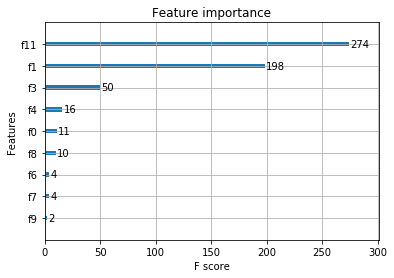

In [172]:
xgb.plot_importance(BST)
plt.show()

In [155]:
# the format of using our validation function is:
params = { 
                'eta'             : 0.4,
                'nround'          : 3000,
                'colsample_bytree': 0.9}


validationErrorLog, trainingErrorLog = \
    crossValidationTimeSeries(dataTrainNumericalLog, labelTrainLog, 5, dataTestNumericalLog, params, True, True, 7, None)

BSTLog, predictionLog = XGBoostTrain(dataTrainNumericalLog, dataTestNumericalLog, labelTrainLog, params, None, True, True, 7,
                                     dataRawTestZero, 4, 1)
print(predictionLog)

validation error15675886.664217616
training error23968413.438446186
[  3.05204429e+04   4.46577142e+04   1.45158279e+05 ...,   9.67828671e+04
   8.26601802e+10   1.73223895e+04]


validation error16020536.764524436
training error5858133.126955894
[  2.92952803e+04   4.51116815e+04   1.07662423e+05 ...,   8.69937955e+04
   3.07346087e+10   2.42095093e+04]


validation error8858.70758624726
training error14246611.70029662
[  1.92660624e+04   2.72063851e+04   8.45967493e+04 ...,   6.18384614e+04
   4.28075051e+10   2.28880125e+04]


validation error25868.009523670695
training error8351799.677948182
[  2.18763823e+04   3.23285668e+04   1.06207696e+05 ...,   7.15715124e+04
   2.89710431e+10   1.83077380e+04]


validation error43286.93589605044
training error4996530.900388788
[  2.01096744e+04   3.36256889e+04   9.00849739e+04 ...,   8.33687327e+04
   2.12509031e+10   1.80231573e+04]
6354887.416349604


[  2.24816427e+04   3.84888794e+04   9.79955717e+04 ...,   8.10912588e+04
   3.60845169e+10   2.11649990e+04]


In [139]:
BSTLog, predictionLog = XGBoostTrain(dataTrainNumericalLog, dataTestNumericalLog, labelTrainLog, params, None, True, True, 7,
                                     dataRawTestZero, 4, 1)

[ 0.01805487  0.016893    0.01399839 ...,  0.01425388  0.00642419
  0.02203563]


[ 10.02045438  10.55812463  11.49267757 ...,  11.30333045  24.30912971
   9.96010411]
[  2.24816427e+04   3.84888794e+04   9.79955717e+04 ...,   8.10912588e+04
   3.60845169e+10   2.11649990e+04]


# Ensemble on many models from sklearn ML framework

#### Floating number converted training and testing data for SKLearn Regressors

In [99]:
trainData = dataTrainNumerical.astype(float)
testData = dataTestNumerical.astype(float)
trainDataLog = dataTrainNumericalLog.astype(float)
testDataLog = dataTestNumericalLog.astype(float)
labelLog = labelTrainLog.astype(float)
label = labelTrain.astype(float)

#### Cross validation for sklearn models

In [100]:
def evalErrorSKLearn(prediction, realLabel, logBoolean):
    # Root Mean Square Percentage Error (RMSPE), return a floating number
    N = realLabel.shape[0]
    error = 0
    for i in range (N):
        t = realLabel[i]
        p = prediction[i]
        if (logBoolean):
            t = math.exp(t)
            p = math.exp(p)
        error += ((p-t)/t)**2
    return float((error/N)**(1/2))

In [101]:
def crossValidationSKLearnLinearModel(trainData, label, testData, kFold, logBoolean, SKLearn, **para):
    # para is the optional parameters we want to pass in to respective SKLearn linear models
    # SKLearn is the linear model we want to test out
    N = trainData.shape[0]
    resultant_validation_error_list = []
    resultant_training_error_list = []
    k = int(math.floor(N/(kFold+1)))
    # print(k)
    
    for multiplier in range(kFold, 0, -1): # the training data we have is in the reverse of time
        
        trainingSet = trainData[k*multiplier:,:]
        validationSet = trainData[k*(multiplier-1):(k*multiplier), :]
        trainingLabel = label[k*multiplier:]
        validationLabel = label[k*(multiplier-1):(k*multiplier)]
        
        # modelling and prediction
        model = SKLearn(**para)
        model.fit(X = trainingSet, y = trainingLabel)
        validationPrediction = model.predict(X = validationSet)
        trainingPrediction = model.predict(X = trainingSet)
        prediction = model.predict(X = testData)
        if (logBoolean):
            prediction = restoreExponential(prediction)
        
        # error calculation
        validationError = evalErrorSKLearn(validationPrediction,validationLabel, logBoolean)
        trainingError = evalErrorSKLearn(trainingPrediction, trainingLabel, logBoolean)
        
        # result display
        print(validationError)
        print(trainingError)
        print(prediction)
        
        resultant_validation_error_list.append(validationError)
        resultant_training_error_list.append(trainingError)
    # final validation error display
    print(float(sum(resultant_validation_error_list)/len(resultant_validation_error_list))) #average validation error
    return resultant_validation_error_list, resultant_training_error_list

In [102]:
def SKLearnTrain(trainData, label, testData, logBoolean, SKLearn, **para):
    model = SKLearn(**para)
    model.fit(X = trainData, y = label)
    prediction = model.predict(X = testData)
    if (logBoolean):
        prediction = restoreExponential(prediction)
    res = restoreZeroEntryInPrediction(prediction, dataRawTestZero, 4)
    print (res)
    return res

In [103]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainData, label, testData, 5, False, ensemble.AdaBoostRegressor, 
                                      n_estimators=5, loss='exponential', learning_rate=0.3)
prediction_ada = SKLearnTrain(trainData, label, testData, False, ensemble.AdaBoostRegressor,
             n_estimators=5, loss='exponential', learning_rate=0.3)

0.24837925804015928
0.19991374477420376
[  6186.99592668   7092.47147147   7618.9663437  ...,   8929.07481126
  21922.6125       6186.99592668]
0.31005533898112525
0.22682466489437347
[  6264.61376623   6264.61376623   7529.64416347 ...,   7529.64416347
  21333.95850622   4372.13130194]


0.2884385648702199
0.23918900500799845
[  6105.85766974   6335.20650458   7233.7828233  ...,   7233.7828233
  21592.15274151   4196.76438506]


0.27996529970447065
0.23597325850415576
[  5761.87511588   6574.18398701   6904.15039578 ...,   6904.15039578
  21318.1236715    5463.76793184]


0.27190291587779863
0.24300075408346533
[  5882.03434066   6114.08799146   6959.93963255 ...,   6959.93963255
  20781.43099274   4087.43752799]
0.27974827549475473


[  5675.04629695   5929.51126266   6796.09085862 ...,   6796.09085862
  20338.8366718    5214.74197643]


In [105]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainDataLog, labelLog, testDataLog, 5, True, ensemble.AdaBoostRegressor, 
                                      n_estimators=15, loss='exponential', learning_rate=0.5)
prediction_ada = SKLearnTrain(trainDataLog, labelLog, testDataLog, True, ensemble.AdaBoostRegressor,
             n_estimators=15, loss='exponential', learning_rate=0.5)

0.2369394094206078
0.18591413517599126
[  5828.12680566   6525.57289411   8407.89212128 ...,   7975.48130841
  19360.99335747   5025.02611616]


0.21228093446581162
0.1953448537053547
[  5744.27502495   6548.951484     7917.28567562 ...,   7870.14923118
  18101.30396021   5078.1042291 ]


0.22028701809407575
0.19675538423617775
[  6007.07979412   6224.24278039   8148.31531699 ...,   7983.24601272
  18445.43871875   5887.34889859]


0.2398867180406944
0.20139094825953133
[  5590.56281256   6011.88955529   8001.1885401  ...,   7586.56018881
  17723.69767976   4920.63338622]


0.2115763999632089
0.20171997398851083
[  5814.67667927   5829.48557242   7872.04161958 ...,   7679.31835792
  17308.11207879   5703.20577697]
0.2241940959968797


[  5780.34624755   5978.11687436   7857.58098857 ...,   7799.56819865
  17428.59383629   4757.55490402]


In [107]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainData, label, testData, 5, False, ensemble.BaggingRegressor,
                                      n_estimators = 10, max_samples = 1.0, max_features = 1.0)
prediction_bag = SKLearnTrain(trainData, label, testData, False, ensemble.BaggingRegressor,
                              n_estimators = 10, max_samples = 1.0, max_features = 1.0)

0.09064786468009067
0.02778703629313699
[  4900.4   5959.7   8339.6 ...,   8465.8  29209.4   7198.9]


0.08956076235253671
0.029506365986918043
[  5221.1   6156.4   8715.3 ...,   8399.8  27933.4   6804.4]


0.09157308551071577
0.03152245621880238
[  5222.2   6254.8   8561.3 ...,   8440.3  27754.5   7193.1]


0.10828343717348433
0.03194746791087417
[  5012.3   6154.1   8482.  ...,   8338.5  27762.2   7291.1]


0.07910908474934915
0.03414475611803851
[  4937.225   5862.5     8573.8   ...,   8336.4    26914.3     7049.7  ]
0.09183484689323532


[  4781.1   5933.1   8543.5 ...,   8354.2  26768.8   7236.5]


In [109]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainDataLog, labelLog, testDataLog, 5, True, ensemble.BaggingRegressor,
                                      n_estimators = 15, max_samples = 1.0, max_features = 1.0)
prediction_bag = SKLearnTrain(trainDataLog, labelLog, testDataLog, True, ensemble.BaggingRegressor,
                              n_estimators = 15, max_samples = 1.0, max_features = 1.0)

0.15807102148677118
0.053024911538824104
[  5166.63742551   6306.50684028   8790.51929804 ...,   7652.89466801
  28213.1730355    6232.52535985]


0.1628971013104506
0.05139654257041346
[  5347.09042554   6318.24221639   8567.8238541  ...,   7923.22428677
  27358.41099625   6389.07738107]


0.15449032697017795
0.05092557910762369
[  5624.75244256   5967.35865365   8966.62274873 ...,   7083.25979943
  28409.04863852   6324.89200075]


0.14882283184167744
0.05020642372115892
[  4555.76444769   5575.96545538   8584.75357549 ...,   8097.49876304
  28081.75104706   6989.21528922]


0.12012615194254325
0.04936739338034706
[  4487.75851454   5739.87073469   8269.38573548 ...,   8228.33783744
  27506.91625712   7324.19386222]
0.14888148671032408


[  4610.63143654   5830.50639573   8539.53623448 ...,   8245.06741716
  27183.70289334   7564.2921274 ]


In [111]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainData, label, testData, 5, False, ensemble.ExtraTreesRegressor)
prediction_extra_tree = SKLearnTrain(trainData, label, testData, False, ensemble.ExtraTreesRegressor)

0.08841322208393496
0.0052291569013782025
[  5095.7   6127.1   8639.7 ...,   8419.3  29016.    7144.7]


0.09174280914382878
0.006553311539475561
[  5137.7   6285.9   8782.4 ...,   8631.9  26380.    7360.3]


0.09664937431541754
0.007570218384525077
[  5355.3   5958.5   8661.3 ...,   8217.3  26380.    7381.8]


0.11006925045243947
0.00849858329337559
[  4800.6   6176.8   7992.1 ...,   8301.3  27196.    7225.5]


0.08213457076616987
0.010062349500653097
[  5136.6   6067.2   8268.3 ...,   8038.7  26924.    7006.7]
0.09380184535235812


[  4787.13333333   5851.8          8255.7        ...,   8120.8         26652.
   7112.9       ]


In [113]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainDataLog, labelLog, testDataLog, 5, True, ensemble.ExtraTreesRegressor)
prediction_extra_tree = SKLearnTrain(trainDataLog, labelLog, testDataLog, True, ensemble.ExtraTreesRegressor)

0.17158884196048207
0.005208057355802583
[  5534.34994762   6130.04615679   8865.31008874 ...,   7542.89351144
  28364.41498728   6838.1463513 ]


0.17760327639172988
0.00652632572332984
[  5661.98540231   6155.03573953   9096.42989478 ...,   7675.94759824
  27182.5528747    6854.21982611]


0.16721555540921598
0.0075331587029539866
[  5584.63249735   6276.52988202   9367.50141637 ...,   7515.34685225
  27382.31811728   6598.86543415]


0.16352940772344873
0.008445821240725588
[  4633.17155046   5928.76821421   9397.33003762 ...,   6935.14666497
  27141.52971795   6723.61675555]


0.13794816942281987
0.009986205960467995
[  4729.68386558   5683.60922488  10215.19889843 ...,   8702.04878472
  27114.92402154   7326.91645246]
0.16357705018153929


[  4846.86301878   5815.24375336   9158.60131529 ...,   7848.82083006
  26876.48697158   6986.36900361]


In [115]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainData, label, testData, 5, False, ensemble.GradientBoostingRegressor)
prediction_extra_tree = SKLearnTrain(trainData, label, testData, False, ensemble.GradientBoostingRegressor)

0.08187041462833741
0.06046621315913816
[  5251.73740303   6344.71156277   8179.52105784 ...,   8507.18125063
  27674.07247226   7235.24626303]


0.08772149110951424
0.06689914270362823
[  5430.04000446   6313.47298446   8529.28830272 ...,   8578.73059588
  27973.18919319   7326.21238095]


0.1004724197594202
0.07093225401450587
[  5447.77275433   6526.7521546    8360.38123509 ...,   8565.03442424
  27043.08745663   7424.37029525]


0.1112324812256711
0.07380173628714944
[  5196.47636986   6096.33091825   8278.05271383 ...,   8470.02948646
  26842.63890823   7318.19517458]


0.08191468073602458
0.07770111802065668
[  5170.7547006    6021.35041141   8069.80273802 ...,   8238.38109336
  26266.78276124   7061.12800618]
0.09264229749179351


[  5080.92886499   5987.80080632   8271.56783726 ...,   8034.40722239
  26431.55261939   7182.06966276]


In [117]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainDataLog, labelLog, testDataLog, 5, True, ensemble.GradientBoostingRegressor)
prediction_extra_tree = SKLearnTrain(trainDataLog, labelLog, testDataLog, True, ensemble.GradientBoostingRegressor)

0.16063190684486356
0.1415225685926502
[  5561.57790107   6251.12737776   7885.93553689 ...,   8174.07308375
  25503.90673882   6271.68162482]


0.1502795383013077
0.14649535012908332
[  5648.46217826   6220.53775828   8042.09070911 ...,   7969.52612183
  25823.80157763   6402.53698555]


0.16965587498384116
0.14422467067004116
[  5697.03523919   6373.44747594   7940.89920942 ...,   8247.55579154
  25977.04960064   6219.16055078]


0.17390270786640954
0.14650494548024917
[  5340.10590074   6157.05777289   7683.4722772  ...,   7913.07094693
  25343.56316139   6170.68669627]


0.1548587855850686
0.14919420498419741
[  5311.61592814   5981.28736903   7696.37304616 ...,   7716.85855836
  25528.83797183   6060.24393533]
0.1618657627162981


[  5261.768563     6110.62510035   7635.14480064 ...,   7815.58070686
  24595.4405214    6052.71533632]


In [119]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainData, label, testData, 5, False, ensemble.RandomForestRegressor,
                                      n_estimators=15, max_features = 'auto')
prediction_extra_tree = SKLearnTrain(trainData, label, testData, False, ensemble.RandomForestRegressor,
                                     n_estimators=15, max_features = 'auto')

0.0898301877708355
0.026416605965519188
[  4846.26666667   6071.46666667   8349.         ...,   8446.          27721.
   7344.33333333]


0.08890272457319648
0.028080125674715458
[  5094.93333333   6175.13333333   8418.86666667 ...,   8610.66666667
  28559.13333333   7082.86666667]


0.09024594298512285
0.029878155264736177
[  5040.46666667   6029.53333333   8403.53333333 ...,   8324.13333333
  28169.13333333   7094.2       ]


0.10721420579049352
0.03044896414053016
[  5003.72777778   6160.46666667   8322.33333333 ...,   8170.33333333
  26791.6          7267.13333333]


0.07822186060522744
0.032630229334477394
[  4758.24444444   5958.46666667   8564.28888889 ...,   8167.06666667
  26337.13333333   7116.4       ]
0.09088298434497516


[  4655.85396825   5982.           8688.         ...,   8300.4         27550.4
   7051.26666667]


In [121]:
validationList, trainingList = \
    crossValidationSKLearnLinearModel(trainDataLog, labelLog, testDataLog, 5, True, ensemble.RandomForestRegressor)
prediction_extra_tree = SKLearnTrain(trainDataLog, labelLog, testDataLog, True, ensemble.RandomForestRegressor)

0.16300365246500761
0.05543382278264135
[  5686.78092045   6179.57760319   8356.02918493 ...,   7593.6009153
  27672.55946445   6367.01948284]


0.1665575905636042
0.05408727423804904
[  5881.09395101   6428.48293929   9280.09572211 ...,   7630.30350646
  28753.43499973   6464.25860669]


0.15708347867300565
0.053575219183924536
[  5996.19946629   6370.56651947   8779.66000561 ...,   7742.26066771
  27786.68191315   6712.7670496 ]


0.15083872889925143
0.05300067315642066
[  4963.06598675   5527.9017218    8494.83432573 ...,   7929.95291424
  28522.39575289   7298.02725584]


0.12211854389893957
0.05228013824787389
[  4572.17446612   5760.71100333   8513.52434325 ...,   8675.08172641
  28616.51746958   7077.58858612]
0.1519203988999617


[  4448.11205802   5987.45990771   8602.0066368  ...,   8314.75566008
  28739.87203389   7140.22156749]


In [159]:
filePath = os.path.join(directory_path, 'prediction_16.csv')
writeToFile(prediction, filePath)


In [158]:
prediction.shape

(33450,)